<img src="C:\Users\Win10\Desktop\amazon.jpg">


Product reviews are becoming more and more important with the evolution of traditional retail stores to online shopping. Consumers are posting reviews directly on product pages in real time. With the vast amount of customer reviews, this creates an opportunity to see how the market reacts to a specific product. 
Sentimental Analysis is intended to aim at textual analysis of subjective/sentimental remarks and infer their statistical equivalence. This proposal considers comments made on and the ratings rated to online product purchases made by users in Amazon. Amazon data are pursued especially since they are abundantly available for Amazon product reviews, although this implementation can be extended to any instance of this paradigm.
The goal of this project is to predict the rating of a product based on reviews, so that a user can decide whether to buy the product or not just looking at ratings instead of reading all the reviews. The project can be used to any dataset which involves user reviews and can predict its ratings.


##  Import all the libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import re
import sys
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from wordcloud import WordCloud

The dataset can be downloaded from http://jmcauley.ucsd.edu/data/amazon/.

Amazon Sports and Outdoors Dataset has been used in this project. Since the file is in json format, read_json is used to load the file into Pandas Dataframe. 

We will be covering the binary classification of the reviews i.e.; if the review of the product is positive or negative.

In [3]:
final_data = pd.read_json(r"C:\Users\Win10\Desktop\Sports_and_Outdoors_5.json", lines=True)
final_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296337 entries, 0 to 296336
Data columns (total 9 columns):
asin              296337 non-null object
helpful           296337 non-null object
overall           296337 non-null int64
reviewText        296337 non-null object
reviewTime        296337 non-null object
reviewerID        296337 non-null object
reviewerName      294935 non-null object
summary           296337 non-null object
unixReviewTime    296337 non-null int64
dtypes: int64(2), object(7)
memory usage: 20.3+ MB


## Viewing the general information:
When viewing the general information there are a few things that can be observed. The columns in the dataframe are:

- asin - ID of the product, e.g. 0000013714
- helpful - helpfulness rating of the review, e.g. 2/3
- overall - rating of the product
- reviewText - text of the review
- reviewTime - time of the review (raw)
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- reviewerName - name of the reviewer
- summary - summary of the review
- unixReviewTime - time of the review (unix time)

The columns "reviewText" & "summary" appears to be the sentiments that seems fit to be used for sentiment analysis.
There aren't any column to determine if the review is positive or negative. We will have to use the column "overall" as a road map. 


In [4]:
final_data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1881509818,"[0, 0]",5,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200
3,1881509818,"[0, 0]",4,This works no better than any 3/32 punch you w...,"02 5, 2012",A148SVSWKTJKU6,"Jusitn A. Watts ""Maverick9614""",It's a punch with a Glock logo.,1328400000
4,1881509818,"[0, 0]",4,I purchased this thinking maybe I need a speci...,"04 23, 2013",AAAWJ6LW9WMOO,Material Man,"Ok,tool does what a regular punch does.",1366675200


## Common Reviewers:
After taking a look at the common reviewers by the "reviewerName" column, it appears there aren't any information that can be derived from this column. This is due to "Amazon Customer and other common names appears to be the individuals that are leaving these reviews. It would be hard to believe that there is one individual named Mike that reviewed 612 sports items. It would be safer to assume that there were many individuals named Mike that were leaving a review.

When looking at the column "reviewerID", this provides more information that can be digested or will prove to be useful. As there are many reviewer ID's that are in the hundreds which means that these reviewers are leaving multiple reviews. It would be prudent to dig deeper to see the mean of the helpfulness of the reviews that these individuals are leaving or even the percentage mean of the people that feel that their reviews are helpful. That would be a better indicator whether that particular individual is leaving helpful or unhelpful reviews. This "reviewer rewards program" project will be tabled for another time, as the purpose of the model we are trying to satisfy is to determine whether a review is positive or negative.

In [5]:
final_data.reviewerName.value_counts().head(10)

Amazon Customer    4026
Mike                612
Chris               551
Steve               460
John                435
David               400
Scott               398
Jeff                397
Dan                 354
Matt                354
Name: reviewerName, dtype: int64

In [6]:
final_data.reviewerID.value_counts().head(10)

A3OXHLG6DIBRW8    296
AN81JUYW2SL24     142
AOVTLYTHVDNUX     139
A8VI7KMUHI7ZH     115
A2XRMQA6PJ5ZJ8    103
AO4KJPY9BMJQL     100
A2QGOE9VHBNPKS     97
A2JP9E1H0SF392     96
A37FULV9NLQYXU     94
A2KPDRY4YRR7WP     92
Name: reviewerID, dtype: int64

After reveiwing all the columns, the "reviewText" column seems fit as input data for analyzing sentiments and the "overall" columns can be our target column.

In [7]:
dataset = final_data[["reviewText", "overall"]]
dataset.head()

,reviewText,overall
0,This came in on time and I am veru happy with ...,5
1,I had a factory Glock tool that I was using fo...,5
2,If you don't have a 3/32 punch or would like t...,4
3,This works no better than any 3/32 punch you w...,4
4,I purchased this thinking maybe I need a speci...,4


## Ratings:
Let's determine the ratings by breaking it down to the type of ratings the data contains and distribution of the type of those ratings. Doing so will determine what will be considered to be positive or negative and whether we will have an imbalanced dataset.

In [8]:
print("Unique Ratings: ",dataset.overall.unique())

rating = dataset.overall.value_counts().sort_index(ascending = False)
rating = rating.reset_index()
rating.columns = ["Rating", "Frequency"]
rating["Percentage"] = rating.Frequency / rating.Frequency.sum() * 100
rating

Unique Ratings:  [5 4 3 2 1]


,Rating,Frequency,Percentage
0,5,188208,63.511475
1,4,64809,21.870033
2,3,24071,8.122847
3,2,10204,3.443377
4,1,9045,3.052268


## Pie-chart representation of different ratings

C:\Users\Win10\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  import sys


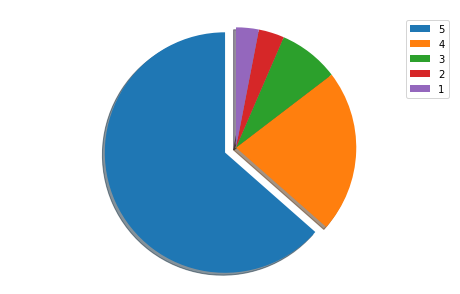

In [9]:
plt.figure(figsize=(8,5))
explode=[0.1,0,0,0,0]
x, y = plt.pie(rating["Percentage"], explode=explode,labels=rating.Rating,shadow=True, #autopct='%1.1f%%',
               startangle=90,textprops={"color":"w", "fontsize":20})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(x, labels = rating.Rating, loc="best")

Creating a new column "Sentiment" based on the overall(rating) column using the logic:
- if rating >= 4, then the review is positive, so the value of Sentiment = 1
- if rating < 3, then the reveiew is negative, so the value of Sentiment = 0
Since we are using binary classification for this project, we are excluding the neutral reviews i.e.; when rating = 3

In [10]:
dataset.loc[dataset.overall >= 4, "Sentiment"] = 1
dataset.loc[dataset.overall < 3, "Sentiment"] = 0
dataset.head()

C:\Users\Win10\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Win10\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,reviewText,overall,Sentiment
0,This came in on time and I am veru happy with ...,5,1.0
1,I had a factory Glock tool that I was using fo...,5,1.0
2,If you don't have a 3/32 punch or would like t...,4,1.0
3,This works no better than any 3/32 punch you w...,4,1.0
4,I purchased this thinking maybe I need a speci...,4,1.0


## Droping rating column and removing null and duplicate values from the DataFrame

In [11]:
dataset = dataset.drop("overall",axis=1)
dataset = dataset.drop(dataset.index[dataset.reviewText.isnull()])
dataset = dataset.drop(dataset.index[dataset.Sentiment.isnull()])
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop = True, inplace = True)
print(dataset.shape)
print(dataset.head())

(272072, 2)
                                          reviewText  Sentiment
0  This came in on time and I am veru happy with ...        1.0
1  I had a factory Glock tool that I was using fo...        1.0
2  If you don't have a 3/32 punch or would like t...        1.0
3  This works no better than any 3/32 punch you w...        1.0
4  I purchased this thinking maybe I need a speci...        1.0


As the number of reviews is very large, approx 270K, training model on such large dataset will require be time consuming and will require a huge memmory space. For this project, we will be considering a fraction of the reviews for each Sentiment type.
We will be using 5000 positive reviews and 5000 negative reviews to prepare our dataset.

In [12]:
final_dataset = pd.DataFrame(dataset[dataset.Sentiment==0][:5000])
final_dataset = final_dataset.append(dataset[dataset.Sentiment==1][:5000])
final_dataset.reset_index(drop=True,inplace=True)

 Cross-checking for any null and duplicate values and downgrading the memory allocation of Sentiment type to int8 for efficient memory utilization


In [13]:
final_dataset.Sentiment = final_dataset.Sentiment.astype("int8")
print(final_dataset.isnull().sum(), final_dataset.duplicated().sum())

reviewText    0
Sentiment     0
dtype: int64 0


In [14]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
reviewText    10000 non-null object
Sentiment     10000 non-null int8
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


In [15]:
final_dataset.Sentiment.value_counts()

1    5000
0    5000
Name: Sentiment, dtype: int64

##  Shuffling the dataset

In [16]:
final_dataset = final_dataset.sample(frac=1).reset_index(drop=True)
final_dataset.head()

,reviewText,Sentiment
0,Just what I expected. Fits well in my 9mm. Abl...,1
1,don't like the stand better than holding in my...,0
2,"The price is really good, but there are reason...",0
3,i have this sling on a 10.5 pound rifle and i...,1
4,I ordered 2 of these for my daughter's bicycle...,0


## Word cloud for positive and negative reviews

(-0.5, 399.5, 199.5, -0.5)

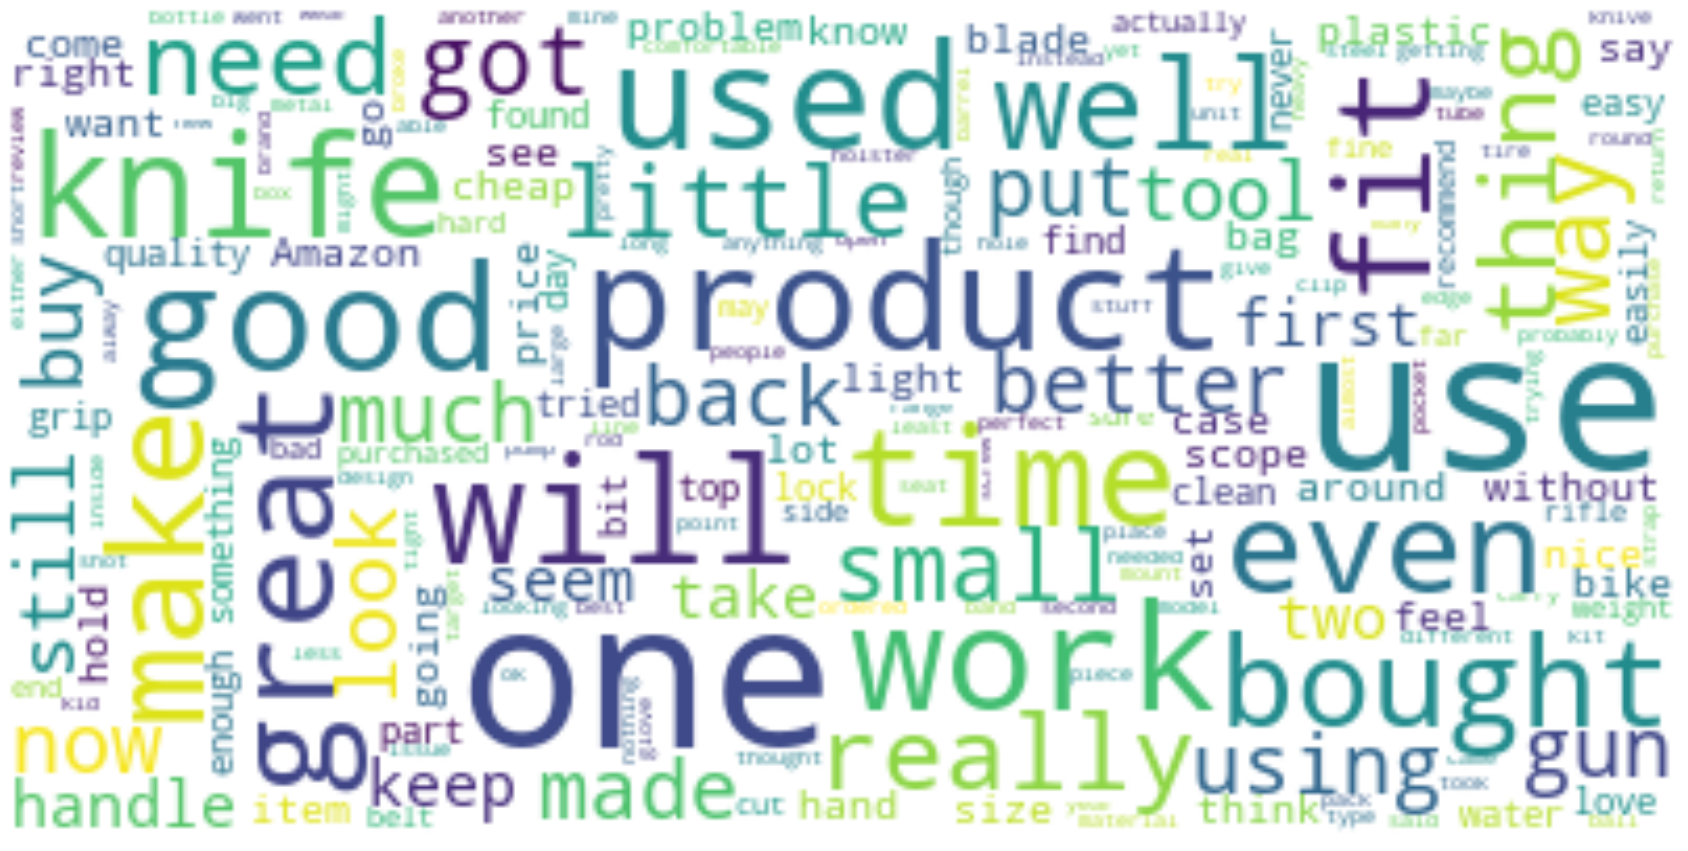

In [17]:
df_p = final_dataset[final_dataset['Sentiment'] == 1]
df_p = final_dataset.reset_index()
df_n = final_dataset[final_dataset['Sentiment'] == 0]
df_n = final_dataset.reset_index()

wordcloud = WordCloud(background_color="white", max_font_size=50).generate(' '.join(df_p['reviewText']))
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

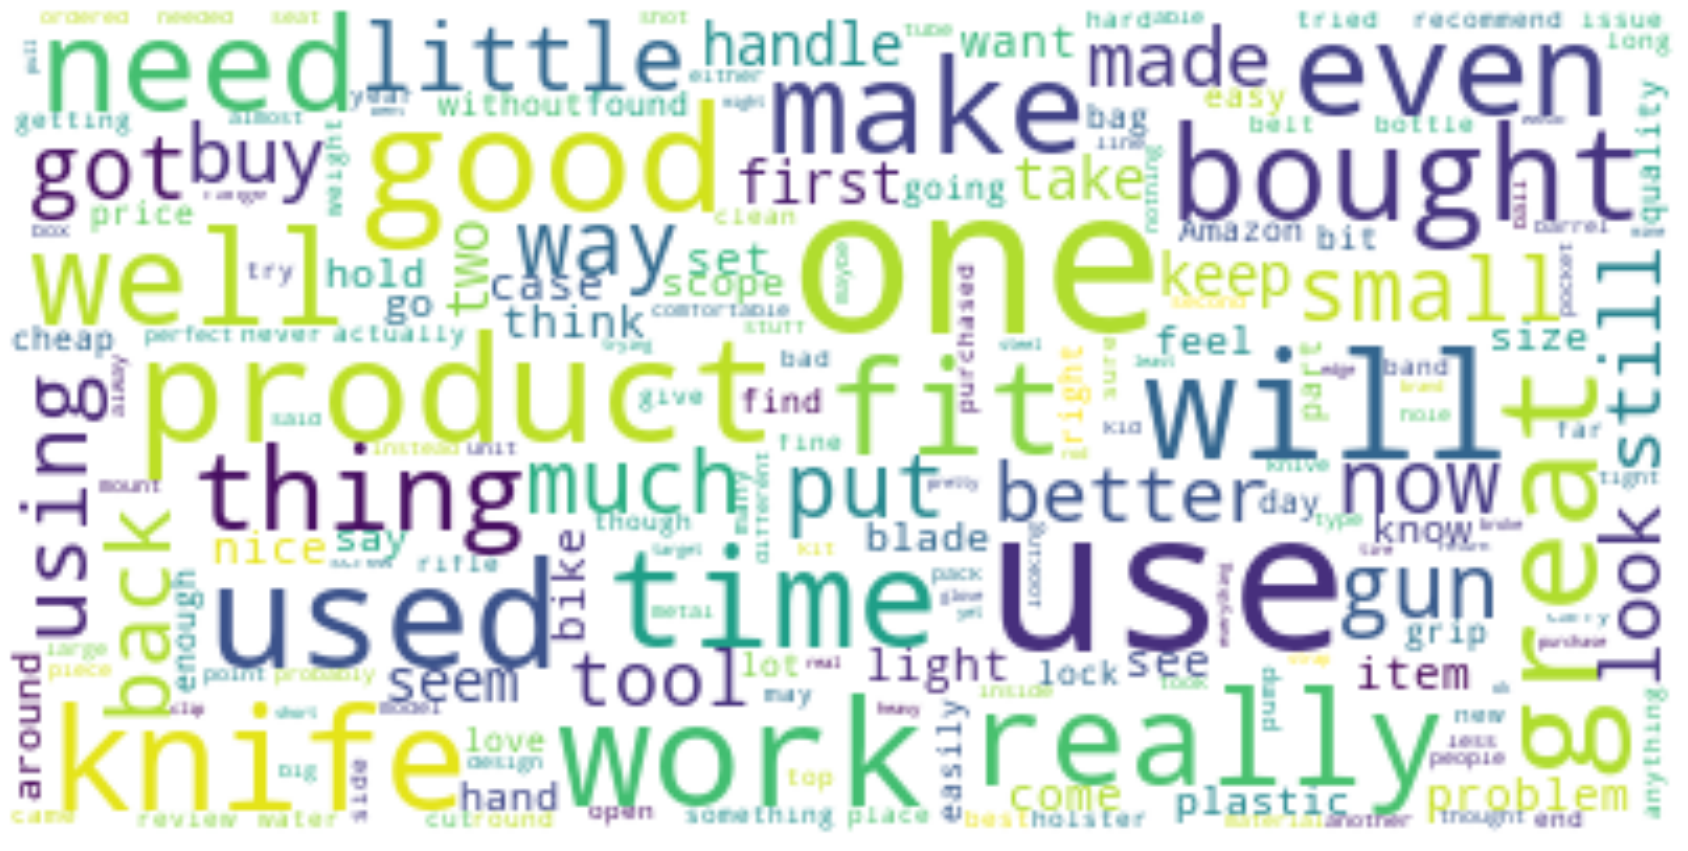

In [18]:
wordcloud = WordCloud(background_color="white", max_font_size=50).generate(' '.join(df_n['reviewText']))
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

##  Use pickle to store the data locally
The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” or “flattening”; however, to avoid confusion, the terms used here are “pickling” and “unpickling”.

In [19]:
pickle_out = open("X.pickle", "wb")
pickle.dump(final_dataset.reviewText, pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle", "wb")
pickle.dump(final_dataset.Sentiment, pickle_out)
pickle_out.close()

## Reload the saved data(unpickle the data)

In [20]:
final_dataset=pd.DataFrame()
pickle_in = open("X.pickle", "rb")
final_dataset["reviewText"] = pickle.load(pickle_in)

pickle_in = open("Y.pickle", "rb")
final_dataset["Sentiment"] = pickle.load(pickle_in)

In [21]:
print(final_dataset.shape)
final_dataset.head()

(10000, 2)


,reviewText,Sentiment
0,Just what I expected. Fits well in my 9mm. Abl...,1
1,don't like the stand better than holding in my...,0
2,"The price is really good, but there are reason...",0
3,i have this sling on a 10.5 pound rifle and i...,1
4,I ordered 2 of these for my daughter's bicycle...,0


Removing the numerical values from the reviews text and keeping only the alphabet characters.

In [22]:
final_dataset.reviewText = [re.sub("[0-9][a-zA-z]*", "", i) for i in final_dataset.reviewText]
final_dataset.head()

,reviewText,Sentiment
0,Just what I expected. Fits well in my . Able t...,1
1,don't like the stand better than holding in my...,0
2,"The price is really good, but there are reason...",0
3,i have this sling on a . pound rifle and it m...,1
4,I ordered of these for my daughter's bicycles...,0


## Split Training & Test Data:
To observe and have confidence that the model is performing well, it is essential to split the dataset to training set and a testing set. Once the model is trained on the training set we will test it against the testing set. Doing so will enable us to see if the trained model is overfitting or it can handle unseen datasets.

In [23]:
##  split datainto test and training set

X_train, X_test, y_train, y_test = train_test_split(final_dataset.reviewText, final_dataset.Sentiment, random_state=0, test_size=0.3)
print("Shape of X train:", X_train.shape)
print("Shape of y train:", y_train.shape)
print("Shape of X test:", X_test.shape)
print("Shape of y test:", y_test.shape)

Shape of X train: (7000,)
Shape of y train: (7000,)
Shape of X test: (3000,)
Shape of y test: (3000,)


## TF-IDF Vectorizer
Text data requires special preparation before you can start using it for predictive modeling. The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating-point values for use as input to a machine learning algorithm, called feature extraction (or vectorization). We can use Count Vectorizer for feature extraction but the issue is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors. An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym that stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.
The TF-IDF Vectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.
setting up the hyperparameters:
- min_df = 6 : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. 
- ngram_range = (1,2) : The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.  For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.


In [24]:
vect = TfidfVectorizer(min_df = 6, ngram_range=(1,2), strip_accents="ascii", stop_words="english")
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_train_dtm

<7000x6513 sparse matrix of type '<class 'numpy.float64'>'
	with 217689 stored elements in Compressed Sparse Row format>

In [25]:
len(vect.get_feature_names())

6513

Display the top 20 terms with most weights

In [26]:
weights = np.asarray(X_train_dtm.mean(axis=0)).ravel().tolist()
print(weights[1])
weights_df = pd.DataFrame({'term': vect.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

0.0004246602543889342


,term,weight
6020,use,0.022508
2330,great,0.020370
2844,just,0.020245
2258,good,0.020111
3151,like,0.018008
4240,product,0.016356
6375,work,0.014088
5756,time,0.013761
535,bought,0.013452
2961,knife,0.013384


## Multinomial Naive Bayes
Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of a feature.
Bayes theorem calculates probability P(c|x) where c is the class of the possible outcomes and x is the given instance which has to be classified, representing some certain features.

P(c|x) = P(x|c) * P(c) / P(x)

Naive Bayes are mostly used in natural language processing (NLP) problems. Naive Bayes predict the tag of a text. They calculate the probability of each tag for a given text and then output the tag with the highest one.
In probability theory, the multinomial distribution is a generalization of the binomial distribution.

GridSearchCV provides exhaustive search over specified parameter values for an estimator. Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. 



In [27]:
params = {"alpha": [0.01, 0.1, 1]}
nbm_clf = GridSearchCV(MultinomialNB(), param_grid = params,cv=5,scoring="roc_auc",return_train_score=True)
nbm_clf.fit(X_train_dtm, y_train)
print(nbm_clf.best_params_)
print(nbm_clf.best_score_)
print("Train scores: ",nbm_clf.cv_results_["mean_train_score"])
print("Test scores: ",nbm_clf.cv_results_["mean_test_score"])

{'alpha': 1}
0.9498809834637967
Train scores:  [0.98796588 0.98580032 0.97960999]
Test scores:  [0.94298715 0.94855106 0.94988098]


## Evaluation metrics:

AUC-ROC curve is one of the most commonly used metrics to evaluate the performance of machine learning algorithms particularly in the cases where we have imbalanced datasets.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point — a false positive rate of zero, and a true positive rate of one. ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction. The predicted class probabilities of an input sample are computed as the weighted mean predicted class probabilities of the classifiers in the ensemble.

In [28]:
#print(roc_auc_score(y_test, nbm_clf.predict(X_test_dtm)))
print(roc_auc_score(y_test, nbm_clf.predict_proba(X_test_dtm)[:,1]))


0.9412627481814996


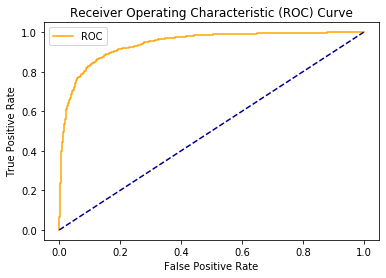

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, nbm_clf.predict_proba(X_test_dtm)[:,1])
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
plot_roc_curve(fpr, tpr)

## Confusion Matrix
A confusion matrix is a summary of prediction results on a classification problem.
The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
The confusion matrix shows the ways in which your classification model is confused when it makes predictions.
It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.
- TP = True Positive – The model predicted the positive class correctly, to be a positive class.
- FP = False Positive – The model predicted the negative class incorrectly, to be a positive class.
- FN = False Negative – The model predicted the positive class incorrectly, to be the negative class.
- TN = True Negative – The model predicted the negative class correctly, to be the negative class.

There are two types of errors that can be identified here:
- Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).
- Type 2 Error: The model predicted the instance to be the Negative class, but is it incorrect. This is False Negative (FN).

Accuracy: Out of all the classes present in the dataset, how many were correctly predicted. 

Recall: Out of all the positive classes, how many instances were identified correctly.

Precision: Out of all the predicted positive instances, how many were predicted correctly.

F-Score: From Precision and Recall, F-Measure is computed and used as metrics sometimes. F – Measure is nothing but the harmonic mean of Precision and Recall.

Predicted     0     1   All
Actual                     
0          1297   165  1462
1           235  1303  1538
All        1532  1468  3000


Accuracy: 0.87
Precision: 0.89
Recall: 0.85
F1 Score: 0.87


Text(0.5, 0, 'Predicted label')

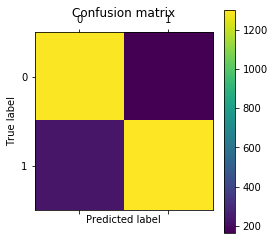

In [30]:
y_pred_nbm = nbm_clf.predict(X_test_dtm)

df_confusion = pd.crosstab(y_test, y_pred_nbm, rownames=['Actual'], colnames=['Predicted'], margins=True)
FP = df_confusion.loc[df_confusion.index == False, True].iloc[0]
TN = df_confusion.loc[df_confusion.index == False, False].iloc[0]
TP = df_confusion.loc[df_confusion.index == True, True].iloc[0]
FN = df_confusion.loc[df_confusion.index == True, False].iloc[0]

print(df_confusion)

print('\n')
Accuracy = (TN+TP)/(FP+TN+TP+FN)
print('Accuracy: {:,.2f}'.format(Accuracy))

Precision = TP/(TP+FP)
print('Precision: {:,.2f}'.format(Precision))

Recall = TP/(TP+FN)
print('Recall: {:,.2f}'.format(Recall))

F1 = 2*(Recall * Precision) / (Recall + Precision)
print('F1 Score: {:,.2f}'.format(F1))

cm = confusion_matrix(y_test, y_pred_nbm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [31]:
X_test[(y_test==1) & (nbm_clf.predict(X_test_dtm)==0)][:5]
X_test[6387]

"First, I would like to say that I really tried to like this knife as I have been looking at them for a number of years.  However, I tend to be extremely picky when it comes to my blades because I us them pretty often and for hard use tasks.  This was going to be my everyday carry, or EDC, knife to have with me at all times.  Despite the excellent price, there were certain quality issues that made me decide not to go with this knife after getting it into my hands.I want to begin with the positives as there are some.  When looking for a knife, you need it to be sharp; this is a sharp knife from the factory.  It'll shave the hair of your arm with ease and rip through cardboard boxes.  The AUS stainless still is adequate, but not the best for edge retention or corrosion resistance.  Again, it is decent.  However, you do not want a $ EDC knife that you ar going to abuse.  The AUS is affordable and easy to sharpen, exactly want you want in a blade of this type.  Also a plus with this knife 

## Precision Recall Curve
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

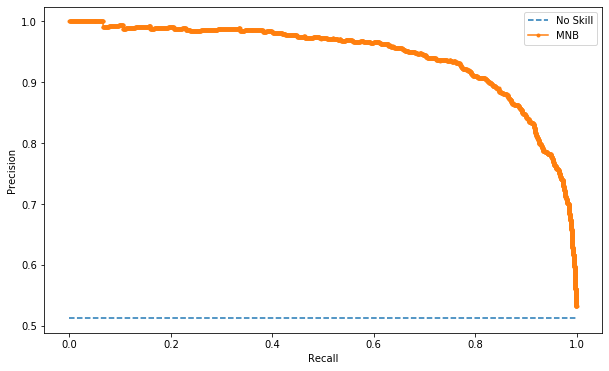

In [32]:
plt.figure(figsize=(10,6))
lr_precision, lr_recall, _ = precision_recall_curve(y_test, nbm_clf.predict_proba(X_test_dtm)[:,1])
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='MNB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

## Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)

Parameters:
- n_estimators(default=100): The number of trees in the forest.
- criterion(default="gini"): The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
- min_samples_split(default=2): The minimum number of samples required to split an internal node:
- min_samples_leaf(default=1): The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.


In [35]:
##  hyper parameters

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 5, 10], "n_estimators": [100, 500, 1000]}

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring="roc_auc", verbose=3, return_train_score=True)
clf.fit(X_train_dtm, y_train)
print(clf.best_params_, clf.best_score_)

C:\Users\Win10\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=1.000, test=0.903), total=   5.5s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=1.000, test=0.918), total=   2.4s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=1.000, test=0.922), total=   2.2s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500 
[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=(train=1.000, test=0.908), total=  10.6s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500 
[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=(train=1.000, test=0.920), total=  11.0s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500 
[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=(train=1.000, test=0.927), total=  10.3s
[CV] criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, score=(train=1.000, test=0.908), total=  21.2s
[CV] criterion=gini, min_samples_leaf=

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 20.3min finished


{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000} 0.9222502086191134


In [43]:
print("Train scores: ",np.mean(clf.cv_results_["mean_train_score"]))
print("Test scores: ",np.mean(clf.cv_results_["mean_test_score"]))
roc_auc_score(y_test, clf.predict_proba(X_test_dtm)[:,1])

Train scores:  0.9772488687182874
Test scores:  0.9172586689117376


0.9212636910088075

In [201]:
clf1 = RandomForestClassifier(criterion='entropy', min_samples_leaf= 1, min_samples_split=2, n_estimators= 1000,
                             max_features='auto', oob_score=True, random_state=1,)
clf1.fit(X_train_dtm, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

## Evaluation metrics for Random Forest

AUC:  0.9212636910088075


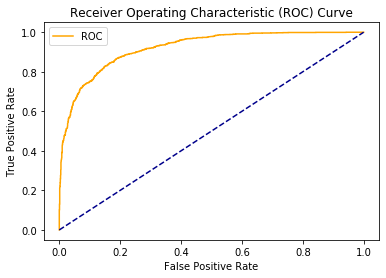

In [44]:
#{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000} 0.9202110004539632
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_dtm)[:,1])
print('AUC: ', roc_auc_score(y_test, clf.predict_proba(X_test_dtm)[:,1]))

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
plot_roc_curve(fpr, tpr)

## Confusion Matrix for Random Forest

Predicted     0     1   All
Actual                     
0          1231   231  1462
1           258  1280  1538
All        1489  1511  3000


Accuracy: 0.84
Precision: 0.85
Recall: 0.83
F1 Score: 0.84


Text(0.5, 0, 'Predicted label')

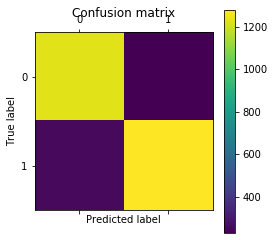

In [45]:
y_pred_rf = clf.predict(X_test_dtm)

df1_confusion = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True)
FP = df1_confusion.loc[df1_confusion.index == False, True].iloc[0]
TN = df1_confusion.loc[df1_confusion.index == False, False].iloc[0]
TP = df1_confusion.loc[df1_confusion.index == True, True].iloc[0]
FN = df1_confusion.loc[df1_confusion.index == True, False].iloc[0]

print(df1_confusion)

print('\n')
Accuracy = (TN+TP)/(FP+TN+TP+FN)
print('Accuracy: {:,.2f}'.format(Accuracy))

Precision = TP/(TP+FP)
print('Precision: {:,.2f}'.format(Precision))

Recall = TP/(TP+FN)
print('Recall: {:,.2f}'.format(Recall))

F1 = 2*(Recall * Precision) / (Recall + Precision)
print('F1 Score: {:,.2f}'.format(F1))

cm1 = confusion_matrix(y_test, y_pred_rf)
plt.matshow(cm1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')


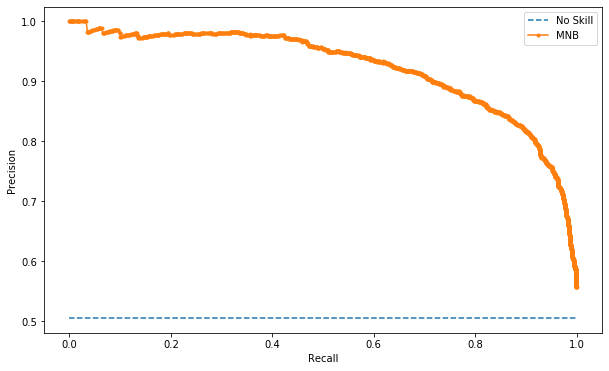

In [203]:
plt.figure(figsize=(10,6))
rf_precision, rf_recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test_dtm)[:,1])
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='MNB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

In [206]:
feature_imp = pd.Series(clf1.feature_importances_, index=vect.get_feature_names()).sort_values(ascending=False)
feature_imp[10:]

bike                6.626720e-03
clean               6.611935e-03
perfect             6.387225e-03
nice                6.068131e-03
price               5.042987e-03
poor                5.006614e-03
broke               4.981630e-03
use                 4.748395e-03
need                4.706962e-03
job                 4.283059e-03
disappointed        4.051403e-03
sent                3.939128e-03
shells              3.838053e-03
highly              3.808717e-03
waste               3.806963e-03
perfectly           3.634177e-03
didn                3.599907e-03
excellent           3.594274e-03
just                3.579780e-03
bad                 3.520025e-03
money               3.484230e-03
works great         3.392869e-03
years               3.335772e-03
holds               3.270808e-03
maybe               3.246113e-03
used                3.216811e-03
bore                3.126779e-03
tried               2.976787e-03
better              2.850233e-03
using               2.818943e-03
          

0.8780227771478202

## Support Vector Machine
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. Hyperplanes are decision boundaries that help classify the data points. 


In [63]:
# defining parameter range 
param_grid = {'C': [ 1, 10],  
              'gamma': [1, 0.1], 
              'kernel': ['linear','rbf']} 

svm_clf = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv = 3, scoring="roc_auc",verbose=3,n_jobs=-1, return_train_score=True)  
svm_clf.fit(X_train_dtm, y_train)
print(svm_clf.best_params_, svm_clf.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.4min remaining:   40.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.6min finished


{'C': 1, 'gamma': 1, 'kernel': 'linear'} 0.9480354378199796


In [65]:
print("Train scores: ",np.mean(svm_clf.cv_results_["mean_train_score"]))
print("Test scores: ",np.mean(svm_clf.cv_results_["mean_test_score"]))
roc_auc_score(y_test, svm_clf.predict_proba(X_test_dtm)[:,1])

Train scores:  0.9975154781080561
Test scores:  0.9393426204285072


0.9454129672554296

In [61]:
svm = SVC(C=1, kernel='linear', probability=True)
#svm_cv = cross_validate(svm, X_train_dtm, y_train, cv=3, return_train_score=True, scoring="roc_auc")
svm.fit(X_train_dtm, y_train)
#svm_cv["test_score"], svm_cv["train_score"]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [62]:
print(np.mean(svm_clf.cv_results_["mean_test_score"]))
print(np.mean(svm_clf.cv_results_["mean_train_score"]))
roc_auc_score(y_test, svm_clf.predict(X_test_dtm))
roc_auc_score(y_test, svm.predict_proba(X_test_dtm)[:,1])


0.9438478483443273
0.9956983941315996


0.9277660863238453

## Evaluation metrics:

AUC:  0.9494253200720818


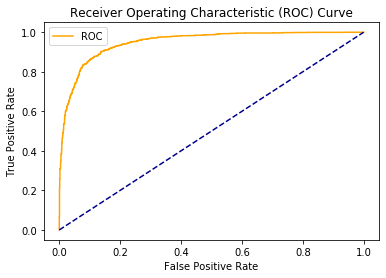

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, svm_clf.predict_proba(X_test_dtm)[:,1])
print('AUC: ', roc_auc_score(y_test, svm_clf.predict_proba(X_test_dtm)[:,1]))

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
plot_roc_curve(fpr, tpr)

## Confusion Matrix for Linear SVM

Predicted     0     1   All
Actual                     
0          1282   180  1462
1           187  1351  1538
All        1469  1531  3000


Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.84


Text(0.5, 0, 'Predicted label')

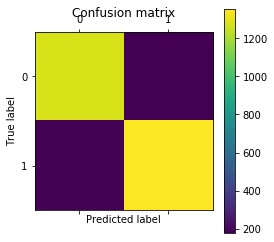

In [66]:
y_pred_svm = svm_clf.predict(X_test_dtm)

df2_confusion = pd.crosstab(y_test, y_pred_svm, rownames=['Actual'], colnames=['Predicted'], margins=True)
FP = df2_confusion.loc[df2_confusion.index == False, True].iloc[0]
TN = df2_confusion.loc[df2_confusion.index == False, False].iloc[0]
TP = df2_confusion.loc[df2_confusion.index == True, True].iloc[0]
FN = df2_confusion.loc[df2_confusion.index == True, False].iloc[0]

print(df2_confusion)

print('\n')
svm_Accuracy = (TN+TP)/(FP+TN+TP+FN)
print('Accuracy: {:,.2f}'.format(svm_Accuracy))

svm_Precision = TP/(TP+FP)
print('Precision: {:,.2f}'.format(svm_Precision))

svm_Recall = TP/(TP+FN)
print('Recall: {:,.2f}'.format(svm_Recall))

svm_F1 = 2*(Recall * Precision) / (Recall + Precision)
print('F1 Score: {:,.2f}'.format(svm_F1))

cm2 = confusion_matrix(y_test, y_pred_svm)
plt.matshow(cm2)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Precision-Recall curve for SVM 

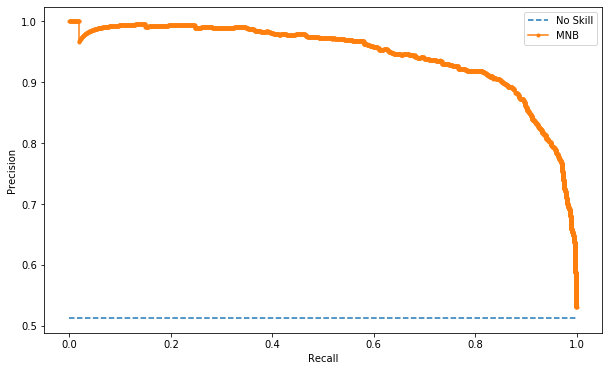

In [67]:
plt.figure(figsize=(10,6))
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_clf.predict_proba(X_test_dtm)[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(svm_recall, svm_precision, marker='.', label='MNB')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

## Conclusion:

******************************************* Multinomial Naive Bayes ************************************

ROC AUC Score = 0.941

F1-Score = 0.87

******************************************* Random Forest Classifier ***********************************

ROC AUC Score = 0.921

F1-Score = 0.84

******************************************* Support Vector Machine *************************************

ROC AUC Score = 0.948

F1-Score = 0.84

From the above scores, it seems Multinomial Naive Bayes is the best among top 3 models.

Final Test:
The example below demonstrates how the model will predict a made up review as a positive or negative review:

In [86]:
## Positive Review 

test_review_array = np.array(['The new iphone x is good, buy it!'])
test_review_vector = vect.transform(test_review_array)
print(nbm_clf.predict(test_review_vector))

[1]


In [87]:
## Negative Review

test_review_array2 = np.array(["The new iphone x is not good and always breaks down, don't buy!"])

test_review_vector2 = vect.transform(test_review_array2)
print(nbm_clf.predict(test_review_vector2))

[0]


#  Copyright 2020 Sachin

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.